In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [4]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='proba')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='proba')
with open('indiv.proba.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.proba.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.3 s, sys: 126 ms, total: 6.43 s
Wall time: 6.83 s


# Traditional SHAP Explanations

In [5]:
with open('indiv.proba.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [6]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

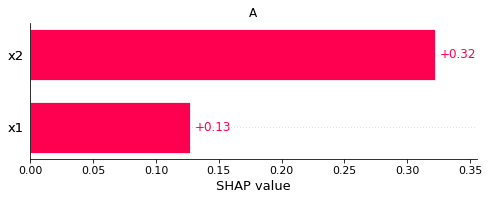

In [7]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

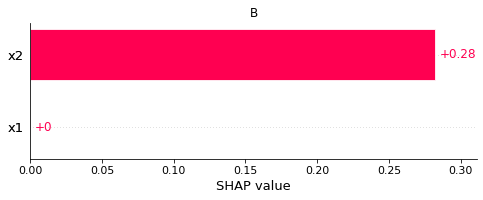

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [9]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 1.32 s, sys: 26.6 ms, total: 1.34 s
Wall time: 1.45 s


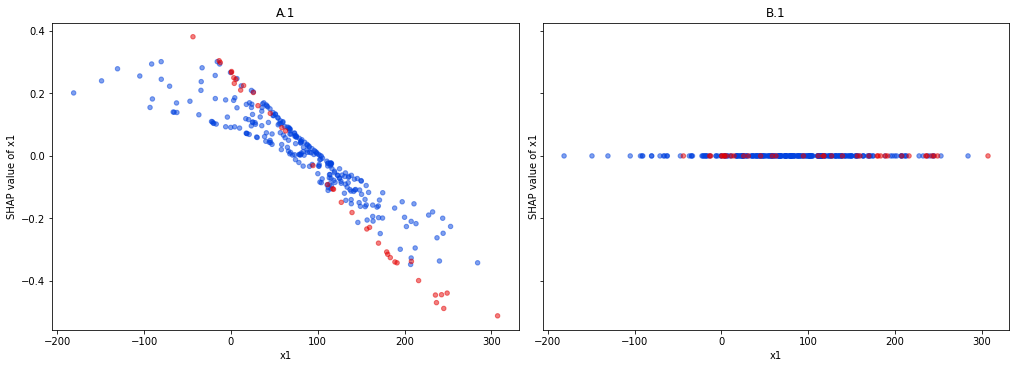

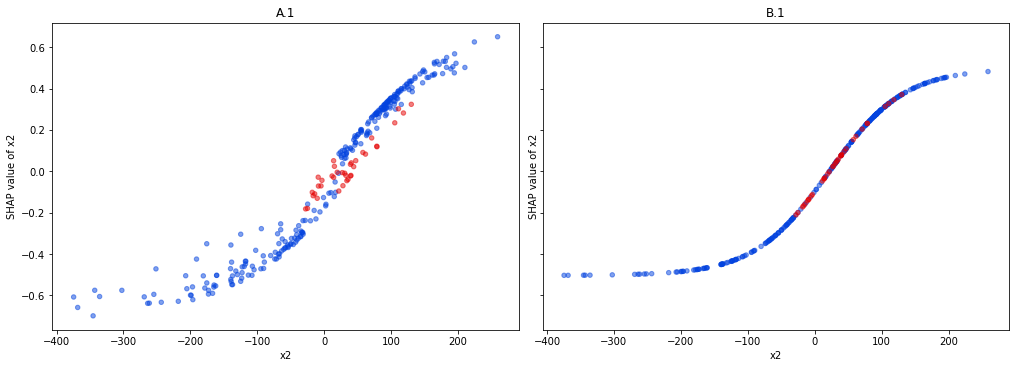

In [10]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [11]:
with open('diffclf.proba.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

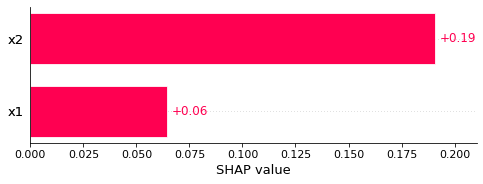

In [12]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

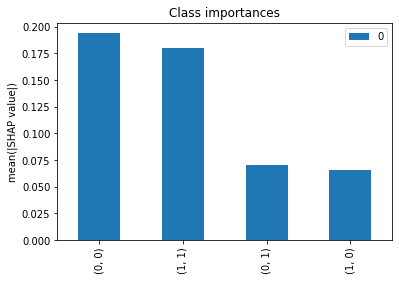

In [13]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [14]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.distance, node.class_counts

CPU times: user 3.5 s, sys: 46.4 ms, total: 3.55 s
Wall time: 3.75 s


(2.8589551366957586,
 (1, 1)    149
 (0, 0)    114
 (0, 1)     22
 (1, 0)     15
 dtype: int64)

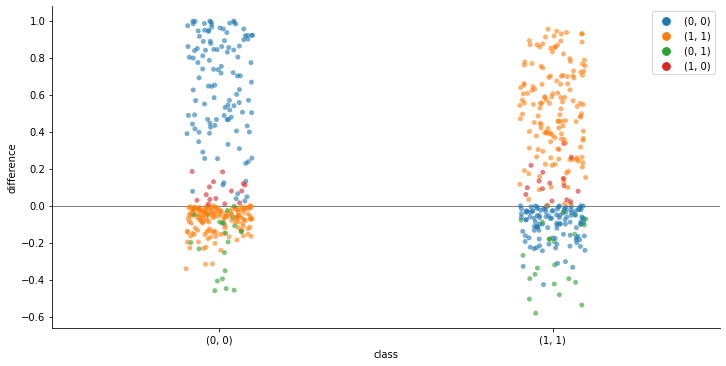

{'(0, 0)': '-0.46 to -0.0', '(1, 1)': '-0.58 to -0.04'}


In [15]:
node.plot_outcome_differences()

### Main Node (R)

In [16]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (1, 1)    149
 (0, 0)     34
 (0, 1)     22
 (1, 0)     15
 dtype: int64,
 1.7585104415387192)

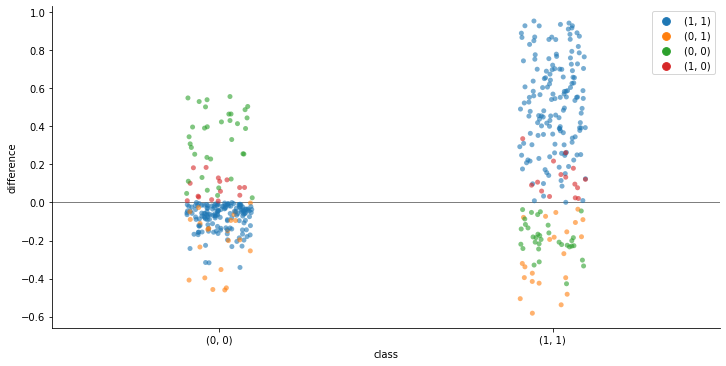

{'(0, 0)': '-0.46 to -0.0', '(1, 1)': '-0.58 to -0.04'}


In [17]:
node.plot_outcome_differences()

94.55361439361346 <= x1
[Lower CF: x1 == 81.0 --> {'(1, 1)': 22}]


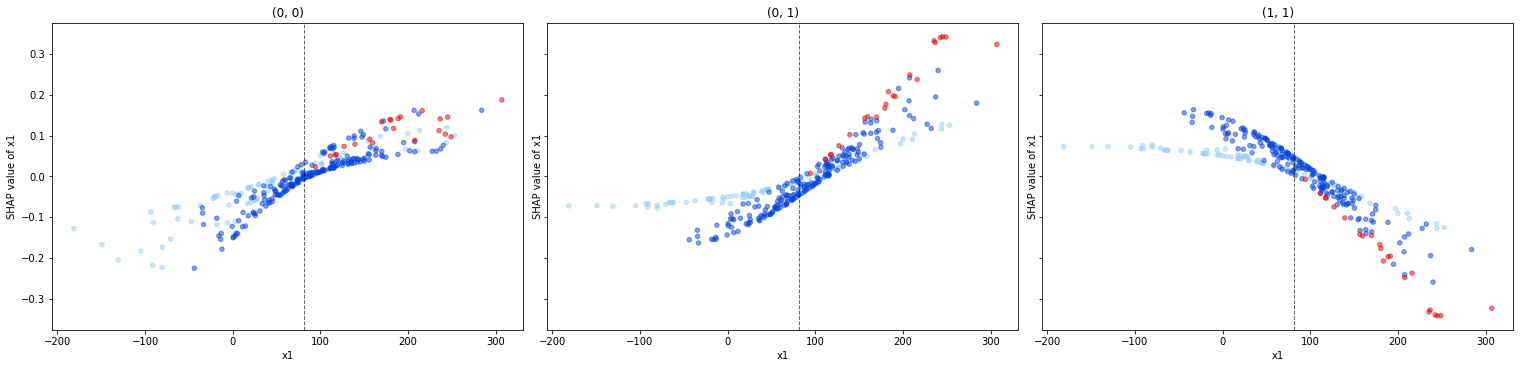

21.71322062603863 <= x2 <= 130.02506989441343
[Lower CF: x2 == 21.0 --> {'(0, 0)': 22},
 Upper CF: x2 == 189.0 --> {'(1, 1)': 22}]


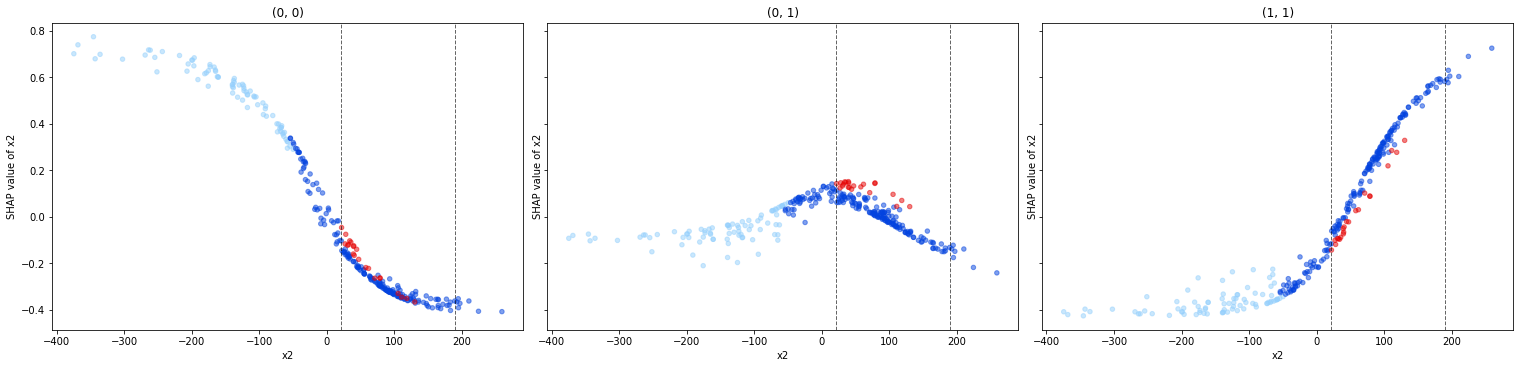

In [18]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    pprint(node.counterfactuals[feature])
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

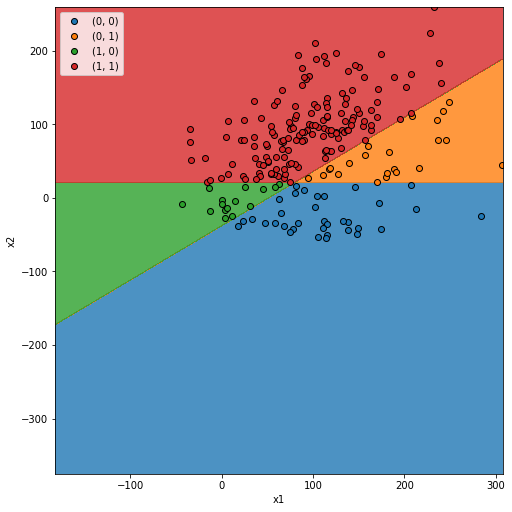

In [19]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim)

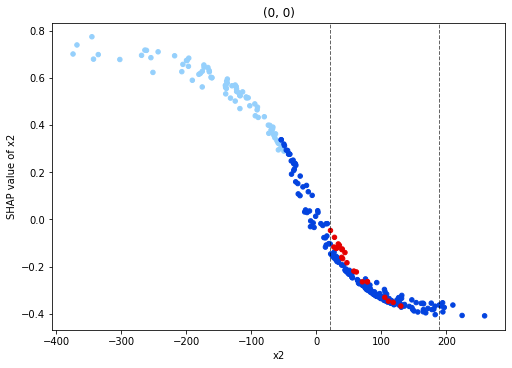

In [20]:
node.root.plot_feature_dependence('x2', focus=node, classes=['(0, 0)'])